![](https://www.dii.uchile.cl/wp-content/uploads/2021/06/Magi%CC%81ster-en-Ciencia-de-Datos.png)


# Proyecto: Riesgo en el Banco Giturra

**MDS7202: Laboratorio de Programación Científica para Ciencia de Datos**

### Cuerpo Docente:

- Profesor: Pablo Badilla, Ignacio Meza De La Jara
- Auxiliar: Sebastián Tinoco
- Ayudante: Diego Cortez M., Felipe Arias T.

_Por favor, lean detalladamente las instrucciones de la tarea antes de empezar a escribir._

---

### Reglas

- Fecha de entrega: 01/06/2021
- **Grupos de 2 personas.**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Estrictamente prohibida la copia.
- Pueden usar cualquier material del curso que estimen conveniente.

---

### Integrantes

- Nombre de alumno 1: Ricardo Espinoza
- Nombre de alumno 2: Cristóbal Guerra

---

### **Link de repositorio de GitHub:** `https://github.com/cristobalg68/Labs-Espinoza-Guerra.git`

# 0. Librerias

In [91]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectPercentile
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# 1. Introducción

El problema planteado es predecir la probabilidad de incumplimiento de pago de los clientes de Giturra. El objetivo es identificar aquellos clientes que presentan un mayor riesgo de impago para tomar decisiones más informadas en cuanto a los préstamos.

Los datos de entrada proporcionados incluyen una amplia gama de variables de los usuarios, como historiales de crédito, ingresos y otros factores financieros relevantes.

Para evaluar los modelos generados, se enfocará en la métrica de recall para la clase positiva ya que esta mide la capacidad del modelo para identificar correctamente los casos positivos, es decir, aquellos clientes que realmente presentan riesgo de impago. Se escoge la métrica de recall dado el desbalanceo presente en los datos (clase positiva es minoritaria), por lo que resulta de mayor relevancia para este contexto que un modelo sea capaz de predecir correctamente la clase positiva sobre la negativa.

# 2. Carga de datos y Análisis Exploratorio de Datos

In [92]:
df = pd.read_parquet("../dataset.pq")
print(df.shape)

(12500, 22)


In [93]:
df.describe()

,age,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,total_emi_per_month,amount_invested_monthly,monthly_balance,credit_score
count,12500.000000,1.250000e+04,10584.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,11660.00000,12246.000000,12243.000000,12500.000000,12500.000000,11380.000000,12500.000000,11914.000000,1.214500e+04,12500.000000
mean,105.771840,1.616206e+05,4186.634963,16.939920,23.172720,73.213360,3.099440,21.060880,32.93542,10.398582,26.292330,1426.220376,32.349265,18.230404,1488.394291,638.798715,-2.744614e+22,0.288160
std,664.502705,1.297842e+06,3173.690362,114.350815,132.005866,468.682227,65.105277,14.863091,237.43768,6.799253,181.821031,1155.169458,5.156815,8.302078,8561.449910,2049.195193,3.024684e+24,0.452924
min,-500.000000,7.005930e+03,303.645417,-1.000000,0.000000,1.000000,-100.000000,-5.000000,-3.00000,-6.490000,0.000000,0.230000,20.100770,0.000000,0.000000,0.000000,-3.333333e+26,0.000000
25%,25.000000,1.945333e+04,1622.408646,3.000000,4.000000,8.000000,1.000000,10.000000,9.00000,5.370000,4.000000,566.072500,28.066517,12.000000,31.496968,73.736810,2.701501e+02,0.000000
50%,33.000000,3.757238e+04,3087.595000,6.000000,5.000000,14.000000,3.000000,18.000000,14.00000,9.410000,6.000000,1166.155000,32.418953,18.000000,72.887628,134.093193,3.393885e+02,0.000000
75%,42.000000,7.269021e+04,5967.937500,7.000000,7.000000,20.000000,5.000000,28.000000,18.00000,14.940000,10.000000,1945.962500,36.623650,25.000000,169.634826,261.664256,4.714245e+02,1.000000
max,8678.000000,2.383470e+07,15204.633333,1756.000000,1499.000000,5789.000000,1495.000000,67.000000,4293.00000,36.970000,2554.000000,4998.070000,48.199824,33.000000,81971.000000,10000.000000,1.463792e+03,1.000000


In [94]:
df.dtypes

customer_id                  object
age                         float64
occupation                   object
annual_income               float64
monthly_inhand_salary       float64
num_bank_accounts             int64
num_credit_card               int64
interest_rate                 int64
num_of_loan                 float64
delay_from_due_date           int64
num_of_delayed_payment      float64
changed_credit_limit        float64
num_credit_inquiries        float64
outstanding_debt            float64
credit_utilization_ratio    float64
credit_history_age          float64
payment_of_min_amount        object
total_emi_per_month         float64
amount_invested_monthly     float64
payment_behaviour            object
monthly_balance             float64
credit_score                  int64
dtype: object

# 3. Preparación de Datos

## 3.1. Datos Nulos, Outliers y Tipo de Datos

In [95]:
df.isnull().sum()

customer_id                    0
age                            0
occupation                     0
annual_income                  0
monthly_inhand_salary       1916
num_bank_accounts              0
num_credit_card                0
interest_rate                  0
num_of_loan                    0
delay_from_due_date            0
num_of_delayed_payment       840
changed_credit_limit         254
num_credit_inquiries         257
outstanding_debt               0
credit_utilization_ratio       0
credit_history_age          1120
payment_of_min_amount          0
total_emi_per_month            0
amount_invested_monthly      586
payment_behaviour              0
monthly_balance              355
credit_score                   0
dtype: int64

In [96]:
df['changed_credit_limit'] = df['changed_credit_limit'].fillna(0)
df = df.dropna()
df.isnull().sum()

customer_id                 0
age                         0
occupation                  0
annual_income               0
monthly_inhand_salary       0
num_bank_accounts           0
num_credit_card             0
interest_rate               0
num_of_loan                 0
delay_from_due_date         0
num_of_delayed_payment      0
changed_credit_limit        0
num_credit_inquiries        0
outstanding_debt            0
credit_utilization_ratio    0
credit_history_age          0
payment_of_min_amount       0
total_emi_per_month         0
amount_invested_monthly     0
payment_behaviour           0
monthly_balance             0
credit_score                0
dtype: int64

Para poder definir los limites utilizados en los filtros se utlizó la función de análisis univariable vista en el laboratorio número 6.

In [97]:
df = df[(df['age'] >= 0) & (df['age'] <= 100)]
df = df[(df['num_bank_accounts'] >= 0) & (df['num_bank_accounts'] <= 20)]
df = df[df['num_credit_card'] <= 40]
df = df[df['interest_rate'] <= 50]
df = df[(df['num_of_loan'] >= 0) & (df['num_of_loan'] <= 20)]
df = df[df['delay_from_due_date'] >= 0]
df = df[df['changed_credit_limit'] >= 0]
df = df[(df['num_of_delayed_payment'] >= 0) & (df['num_of_delayed_payment'] <= 50)]
df = df[df['num_credit_inquiries'] <= 40]
df = df[df['total_emi_per_month'] <= 10000]
df = df[df['monthly_balance'] >= 0]

In [98]:
df.describe()

,age,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,total_emi_per_month,amount_invested_monthly,monthly_balance,credit_score
count,6577.000000,6.577000e+03,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000
mean,33.329938,1.699332e+05,4124.371491,5.426638,5.575490,14.656682,3.548426,21.415083,13.538695,10.536939,6.698191,1447.492249,32.395119,18.057017,130.167959,625.830199,401.488104,0.295271
std,10.748296,1.386808e+06,3167.477209,2.574583,2.131431,8.738085,2.446969,14.848182,6.202121,6.855376,4.002393,1171.605775,5.107529,8.356813,337.514965,2039.390575,210.639100,0.456199
min,14.000000,7.019435e+03,303.645417,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.340000,21.502217,0.000000,0.000000,0.000000,0.382558,0.000000
25%,24.000000,1.918127e+04,1604.147500,4.000000,4.000000,8.000000,2.000000,10.000000,9.000000,5.400000,4.000000,576.840000,28.187172,12.000000,30.453014,73.430550,269.220608,0.000000
50%,33.000000,3.653330e+04,3016.770833,6.000000,5.000000,13.000000,3.000000,18.000000,14.000000,9.410000,6.000000,1180.910000,32.463394,18.000000,68.461289,131.628279,337.032739,0.000000
75%,42.000000,7.183044e+04,5891.615000,7.000000,7.000000,20.000000,5.000000,28.000000,18.000000,15.170000,10.000000,1971.810000,36.664002,25.000000,150.500097,249.555029,468.732351,1.000000
max,56.000000,2.383470e+07,15167.180000,11.000000,38.000000,34.000000,9.000000,67.000000,28.000000,34.850000,26.000000,4998.070000,48.199824,33.000000,8874.000000,10000.000000,1463.792328,1.000000


In [99]:
df['age'] = df['age'].astype('int')
df['num_of_loan'] = df['num_of_loan'].astype('int')
df['num_of_delayed_payment'] = df['num_of_delayed_payment'].astype('int')
df['num_credit_inquiries'] = df['num_credit_inquiries'].astype('int')
df['credit_history_age'] = df['credit_history_age'].astype('int')

In [100]:
df.dtypes

customer_id                  object
age                           int32
occupation                   object
annual_income               float64
monthly_inhand_salary       float64
num_bank_accounts             int64
num_credit_card               int64
interest_rate                 int64
num_of_loan                   int32
delay_from_due_date           int64
num_of_delayed_payment        int32
changed_credit_limit        float64
num_credit_inquiries          int32
outstanding_debt            float64
credit_utilization_ratio    float64
credit_history_age            int32
payment_of_min_amount        object
total_emi_per_month         float64
amount_invested_monthly     float64
payment_behaviour            object
monthly_balance             float64
credit_score                  int64
dtype: object

## 3.2. Feature Engineering

In [101]:
df['rango_etario'] = ["Joven" if a < 18 else ("Adulto-Joven" if (a >= 18) and (a <= 26) else "Adulto") for a in df['age']] 
df['antiguedad_credito'] = ["Nuevo" if a < 18 else "Antiguo" for a in df['credit_history_age']] 
df['debe_mucho'] = ["Si" if o > 1175 else "No" for o in df['outstanding_debt']]

In [102]:
df.shape

(6577, 25)

## 3.3. Prepocesamiento con ColumnTrasformer

In [103]:
set_config(transform_output="default")

categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_columns = ['occupation', 'payment_of_min_amount', 'antiguedad_credito', 'debe_mucho']

standard_scaler = StandardScaler()
standard_columns = ['age', 'num_bank_accounts', 'num_credit_card', 'credit_utilization_ratio']

minmax_scaler = MinMaxScaler()
minmax_columns = ['annual_income', 'monthly_inhand_salary', 'interest_rate', 'num_of_loan', 'delay_from_due_date',
                  'num_of_delayed_payment', 'changed_credit_limit', 'num_credit_inquiries', 'outstanding_debt', 'credit_history_age',
                  'total_emi_per_month', 'amount_invested_monthly', 'monthly_balance']

ordinal_transformer = OrdinalEncoder(categories=[['!@9#%8', 'Low_spent_Small_value_payments', 'Low_spent_Medium_value_payments', 'Low_spent_Large_value_payments',
                                                  'High_spent_Small_value_payments', 'High_spent_Medium_value_payments', 'High_spent_Large_value_payments'],
                                                 ['Joven', 'Adulto-Joven', 'Adulto']])
ordinal_columns = ['payment_behaviour', 'rango_etario']

preprocessor = ColumnTransformer(
    transformers=[('Categorical', categorical_transformer, categorical_columns),
                  ('Ordinal', ordinal_transformer, ordinal_columns),
                  ('Standard Scaler', standard_scaler, standard_columns),
                  ('MinMax Scaler', minmax_scaler, minmax_columns)
                  ])

In [104]:
preprocessor.fit_transform(df)

array([[0.        , 0.        , 0.        , ..., 0.00212038, 0.02189043,
        0.24305943],
       [0.        , 0.        , 0.        , ..., 0.02783326, 1.        ,
        0.61166192],
       [0.        , 0.        , 0.        , ..., 0.10268427, 0.08705224,
        0.27041557],
       ...,
       [0.        , 0.        , 0.        , ..., 0.01178973, 1.        ,
        0.05453544],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01653976,
        0.26544358],
       [0.        , 0.        , 0.        , ..., 0.00289286, 1.        ,
        0.14639261]])

## 3.4. Holdout

In [105]:
X = df.drop(columns=['credit_score'])
y = df['credit_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
target_names = ['NOTRISKY', 'RISKY']

# 4. Baseline

In [106]:
pipelines = {
            "Dummy": Pipeline([
                ('preprocessor', preprocessor),
                ('clf', DummyClassifier(strategy="stratified", random_state=0))
                ]),
            "LogisticRegression": Pipeline([
                ('preprocessor', preprocessor),
                ('clf', LogisticRegression(random_state=0))
                ]),
            "KNeighborsClassifier": Pipeline([
                ('preprocessor', preprocessor),
                ('clf', KNeighborsClassifier())
                ]),
            "DecisionTreeClassifier": Pipeline([
                ('preprocessor', preprocessor),
                ('clf', DecisionTreeClassifier(random_state=0))
                ]),
            "SVC": Pipeline([
                ('preprocessor', preprocessor),
                ('clf', SVC(random_state=0))
                ]),
            "RandomForestClassifier": Pipeline([
                ('preprocessor', preprocessor),
                ('clf', RandomForestClassifier(random_state=0))
                ]),
            "LightGBMClassifier": Pipeline([
                ('preprocessor', preprocessor),
                ('clf', LGBMClassifier(random_state=0))
                ]),
            "XGBClassifier": Pipeline([
                ('preprocessor', preprocessor),
                ('clf', XGBClassifier(seed=0))
                ])
    }

metrics = {}

In [107]:
for pipeline in pipelines:
    pipelines[pipeline].fit(X_train, y_train)
    y_pred = pipelines[pipeline].predict(X_test)
    print(pipeline)
    print(classification_report(y_test, y_pred, target_names=target_names))
    metrics[pipeline] =  recall_score(y_test, y_pred)

Dummy
              precision    recall  f1-score   support

    NOTRISKY       0.72      0.68      0.70      1418
       RISKY       0.28      0.31      0.29       556

    accuracy                           0.58      1974
   macro avg       0.50      0.50      0.50      1974
weighted avg       0.59      0.58      0.59      1974



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression
              precision    recall  f1-score   support

    NOTRISKY       0.81      0.90      0.85      1418
       RISKY       0.64      0.45      0.52       556

    accuracy                           0.77      1974
   macro avg       0.72      0.67      0.69      1974
weighted avg       0.76      0.77      0.76      1974

KNeighborsClassifier
              precision    recall  f1-score   support

    NOTRISKY       0.79      0.85      0.82      1418
       RISKY       0.52      0.43      0.47       556

    accuracy                           0.73      1974
   macro avg       0.66      0.64      0.64      1974
weighted avg       0.72      0.73      0.72      1974

DecisionTreeClassifier
              precision    recall  f1-score   support

    NOTRISKY       0.80      0.79      0.79      1418
       RISKY       0.48      0.49      0.48       556

    accuracy                           0.71      1974
   macro avg       0.64      0.64      0.64      1974
weighted av

In [108]:
df_result = pd.DataFrame(metrics.items(), columns=['CLFS', 'Recall Score'])
df_result.sort_values(by=['Recall Score'], ascending=False)

,CLFS,Recall Score
5,RandomForestClassifier,0.512590
6,LightGBMClassifier,0.507194
7,XGBClassifier,0.500000
3,DecisionTreeClassifier,0.487410
4,SVC,0.464029
1,LogisticRegression,0.446043
2,KNeighborsClassifier,0.429856
0,Dummy,0.311151


De los resultados anteriores se concluye que todos los clasificadores entrenados resultan mejor que el azar (Dummy). De estos, se encontró que el mejor clasificador fue el RandomForestClassifier, ya que posee el recall más alto para la clase "Risky" de entre todos los clasificadores entrenados, con un valor de 0,5126, lo que indica que el modelo es capaz de predecir correctamente el 51% de los casos reales riesgosos ("Risky").

Si el tiempo de entrenamiento es un punto relevante a considerar, es recomendable utilizar clasificadores menos complejos como LogisticRegression, SVC o KNeighborsClassifier que son más rápidos de ejecutar que el resto. Sin embargo, producto de esta menor complejidad, los resultados obtenidos en recall para la clase objetivo pueden verse afectados negativamente y ser menores al de clasificadores más complejos como RandomForestClassifier, LightGBMClassifier o XGBClassifier. Por lo tanto, es necesario encontrar un equilibrio entre tiempo de entrenamiento y rendimiento del modelo considerando las restricciones del modelo y recursos disponibles.

# 5. Optimización de Modelo

In [109]:
pipeline = Pipeline([
    ('preprossesor', preprocessor),
    ('selector', SelectPercentile()),
    ('clf', LGBMClassifier(random_state=0))
    ], memory='.')

parameters = [
    {
        'selector__percentile': [20, 40, 60, 80],
        'clf': [LGBMClassifier(random_state=0)],
        'clf__num_leaves': [30, 50, 70],
        'clf__max_depth': [5, 10, 15],
        'clf__n_estimators': [100, 150, 200]
    }, 
    {
        'selector__percentile': [20, 40, 60, 80],
        'clf': [RandomForestClassifier(random_state=0)],
        'clf__n_estimators': [50, 100, 150],
        'clf__max_depth': [5, 10],
        'clf__criterion': ['gini', 'entropy']
    }
]

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=parameters, 
                           n_jobs=5,
                           scoring='recall',
                           verbose=10)

In [110]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 156 candidates, totalling 780 fits


GridSearchCV(estimator=Pipeline(memory='.',
                                steps=[('preprossesor',
                                        ColumnTransformer(transformers=[('Categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['occupation',
                                                                          'payment_of_min_amount',
                                                                          'antiguedad_credito',
                                                                          'debe_mucho']),
                                                                        ('Ordinal',
                                                                         OrdinalEncoder(categories=[['!@9#%8',
                                                                                                     'Low_spent_Small_value_payments',
                                                                                                     'Low_spent_Medium_value...
                          'clf__n_estimators': [100, 150, 200],
                          'clf__num_leaves': [30, 50, 70],
                          'selector__percentile': [20, 40, 60, 80]},
                         {'clf': [RandomForestClassifier(criterion='entropy',
                                                         max_depth=5,
                                                         n_estimators=150,
                                                         random_state=0)],
                          'clf__criterion': ['gini', 'entropy'],
                          'clf__max_depth': [5, 10],
                          'clf__n_estimators': [50, 100, 150],
                          'selector__percentile': [20, 40, 60, 80]}],
             scoring='recall', verbose=10)

In [111]:
best_estimator = grid_search.best_estimator_
best_estimator

Pipeline(memory='.',
         steps=[('preprossesor',
                 ColumnTransformer(transformers=[('Categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'antiguedad_credito',
                                                   'debe_mucho']),
                                                 ('Ordinal',
                                                  OrdinalEncoder(categories=[['!@9#%8',
                                                                              'Low_spent_Small_value_payments',
                                                                              'Low_spent_Medium_value_payments',
                                                                              'Low_spent_L...
                                                   'num_of_loan',
                                                   'delay_from_due_date',
                                                   'num_of_delayed_payment',
                                                   'changed_credit_limit',
                                                   'num_credit_inquiries',
                                                   'outstanding_debt',
                                                   'credit_history_age',
                                                   'total_emi_per_month',
                                                   'amount_invested_monthly',
                                                   'monthly_balance'])])),
                ('selector', SelectPercentile(percentile=40)),
                ('clf',
                 RandomForestClassifier(criterion='entropy', max_depth=5,
                                        n_estimators=150, random_state=0))])

In [112]:
y_pred = best_estimator.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))
print(f'Recall Score: {recall_score(y_test, y_pred)}')

X does not have valid feature names, but SelectPercentile was fitted with feature names


              precision    recall  f1-score   support

    NOTRISKY       0.84      0.84      0.84      1418
       RISKY       0.59      0.59      0.59       556

    accuracy                           0.77      1974
   macro avg       0.72      0.72      0.72      1974
weighted avg       0.77      0.77      0.77      1974

Recall Score: 0.591726618705036


# 6. Interpretabilidad

Se escogió como método de interpretabilidad la permutación de importancia de sklearn, ya que este nos permite revisar de forma rápida y simple la importancia de las características originales del problema en el pipeline obtenido luego de la optimización. Si bien este no necesariamente es el más adecuado, la rapidez y simplicidad lo hacen idóneo. Por otro lado, el método más indicado habría sido Shap Values, pues este permite revisar la importancia de características de forma global y de forma local. Sin embargo, por temas de tiempo, no se alcanzó a utilizar.

## Caracteristicas más relevantes

In [113]:
result = permutation_importance(best_estimator, X_test, y_test, n_repeats=30, random_state=42)

X does not have valid feature names, but SelectPercentile was fitted with feature names
X does not have valid feature names, but SelectPercentile was fitted with feature names
X does not have valid feature names, but SelectPercentile was fitted with feature names
X does not have valid feature names, but SelectPercentile was fitted with feature names
X does not have valid feature names, but SelectPercentile was fitted with feature names
X does not have valid feature names, but SelectPercentile was fitted with feature names
X does not have valid feature names, but SelectPercentile was fitted with feature names
X does not have valid feature names, but SelectPercentile was fitted with feature names
X does not have valid feature names, but SelectPercentile was fitted with feature names
X does not have valid feature names, but SelectPercentile was fitted with feature names
X does not have valid feature names, but SelectPercentile was fitted with feature names
X does not have valid feature na

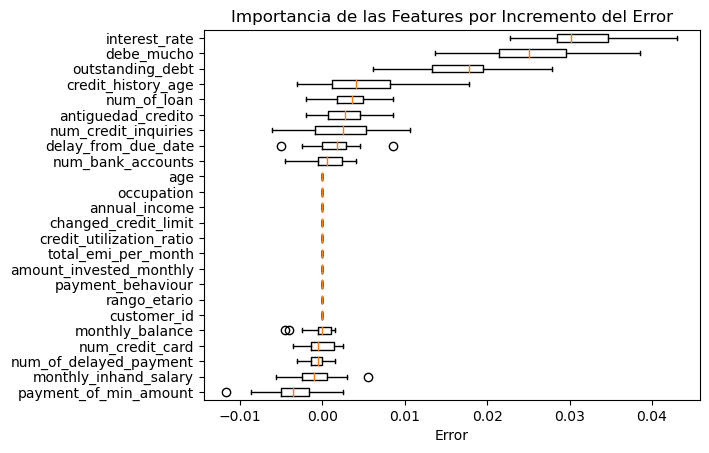

In [114]:
perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=np.array(X_test.columns)[perm_sorted_idx],
)
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')
plt.show()

Muchas de las variables con mayor importancia guardan relevancia a la hora de entender el problema, pues hace sentido que el clasificador utilice variables como el interest_rate, la antigüedad del crédito, la variable creada que indica si una persona debe mucho, el número de préstamos, entre otras.

# 7. Conclusión

En síntesis, sí se logró resolver exitosamente el problema planteado, habiendo obtenido resultados aceptables para la clase “risky” en precisión y recall de 0,59 para ambos casos y resultados muy buenos para la clase “NotRisky”. Con respecto a la importancia del EDA en la comprensión alcanzada sobre los datos, este fue muy relevante ya que en esta etapa se descubrieron los tipos de columnas con las que contaba el dataset, sus distribuciones (para poder realizar escalamiento más adelante), existencia de datos nulos y outliers (para luego realizar filtros), etc.

En relación a la clasificación, el rendimiento de los modelos del baseline fue mediocre dada su simpleza pero sirvió para definir qué modelos continuar optimizando para generar la predicción. De los modelos entrenados en el baseline se escogieron RandomForestClassifier y LightGBMClassifier para optimizar y se llegó a la conclusión de que el mejor pipeline correspondía a un selector de caracteristicas del tipo percentil, escogiendo el percentil 40 y un RandomForestClassifier de las siguientes características:

* criterion = ‘entropy’
* max_depth = 5
* n_estimators = 150

Si bien con este modelo los resultados de la clasificación mejoraron con respecto al baseline en las métricas de precisión y recall para la clase “Risky”, la mejora fue leve y el rendimiento es considerado solo aceptable.

No estamos conformes de los resultados obtenidos, ya que estos son solo un poco mejores que el caso aleatorio y por tanto pueden no ser tan utiles en la practica como para tomar decisiones a partir de ellos. Por ello se plantea modelar el problema con series de tiempo, utilizando registros hitoricos de los clientes y no solamente la última instancia o el promedio de ellas. 

Con respecto a los aprendizajes, se reafirmaron los conocimientos adquiridos durante los laboratorios, revisando desde la exploración de datos, el preprocesamiento de datos, la creación de características, la creación y entrenamiento de pipelines, la optimización de modelos a través de grillas de búsqueda y la intepretabilidad de resultados. Algunos de los conocimientos que nos habría gustado revisar en este curso habrían sido redes neuronales, ya que es un tema recurrente en el área y no visto en esta asignatura.